Now that we have our hatsTrees that have the interesting physical variables calculated, let's do some analysis with them. To combine our MC background samples, we will need to compute weights for them. Fortunately, we have these defined in python `.ini` files.

`.ini` files are a standard format for python configuration files. They have a simple syntax and are quite flexible -- this is another example of where python can help us from falling in the trap of re-inventing the wheel by writing custom code for every simple task, like parsing text files.

Let's take a look at `hatsConfig.ini`.

In [1]:
!cat hatsConfig.ini

[hatsXsects]       #      (pb)
QCD_HT300to500     :   347700.00     
QCD_HT500to700     :    32100.00      
QCD_HT700to1000    :     6831.00       
QCD_HT1000to1500   :     1207.00       
QCD_HT1500to2000   :      119.90      
QCD_HT2000toInf    :       25.24
#Data               :        1.00

[hatsNprocessed]   #  (# processed)
QCD_HT300to500     :     4920846
QCD_HT500to700     :     3845821
QCD_HT700to1000    :     1959216
QCD_HT1000to1500   :    16813667
QCD_HT1500to2000   :    19186048
QCD_HT2000toInf    :    15486719
#Data               :           1


In [2]:
from ConfigParser import RawConfigParser
config = RawConfigParser()   
config.optionxform = str       # Last two lines are done because ConfigParser will not preserve case
config.read("hatsConfig.ini")

['hatsConfig.ini']

Here is a nifty way to create a dict of the cross sections and number of events:

In [3]:
crossSections = dict([sample, float(xsec)] for sample, xsec in config.items('hatsXsects'))
nProcessed    = dict([sample, int(nPro)] for sample, nPro in config.items('hatsNprocessed'))

from pprint import pprint
print "cross sections:" 
pprint(crossSections)
print "number of events processed:"
pprint(nProcessed)

cross sections:
{'QCD_HT1000to1500': 1207.0,
 'QCD_HT1500to2000': 119.9,
 'QCD_HT2000toInf': 25.24,
 'QCD_HT300to500': 347700.0,
 'QCD_HT500to700': 32100.0,
 'QCD_HT700to1000': 6831.0}
number of events processed:
{'QCD_HT1000to1500': 16813667,
 'QCD_HT1500to2000': 19186048,
 'QCD_HT2000toInf': 15486719,
 'QCD_HT300to500': 4920846,
 'QCD_HT500to700': 3845821,
 'QCD_HT700to1000': 1959216}


python `dict`s are extremely useful, because we can give descriptive names to the data they hold. Let's use our dicts to calculate the weights for our MC background samples.

In [4]:
weights = {}
luminosity = 1.42    # This is just an example value
fudge_factor = 1.0/0.313716235739
for sample in crossSections.keys():
    weights[sample] = luminosity * crossSections[sample]*fudge_factor/nProcessed[sample]
weights["data"]=1
pprint(weights)

{'QCD_HT1000to1500': 0.0003249347635425102,
 'QCD_HT1500to2000': 2.8286877228454485e-05,
 'QCD_HT2000toInf': 7.37702544306737e-06,
 'QCD_HT300to500': 0.3198278406930356,
 'QCD_HT500to700': 0.0377804663952992,
 'QCD_HT700to1000': 0.015781682998743433,
 'data': 1}


We can make dicts to hold TChains of all our data, and then draw them with weights:

In [5]:
import ROOT as r

Welcome to JupyROOT 6.08/05


In [7]:
print "Hello World!"

Hello World!


In [8]:
from os import listdir, path, popen
hatsTreesDir = "/store/user/hats/PyRoot/2017/hatsDijetTrees"
hatsChains = {}
for sample in crossSections.keys():
    sampleDir = hatsTreesDir + "/hatsTrees_" + sample
    chain = r.TChain('hatsDijets')
    for hatsFile in filter(None,popen("xrdfs root://cmseos.fnal.gov/ ls -u "+sampleDir).read().split('\n')):
        chain.Add(hatsFile)
    hatsChains[sample] = chain
for hatsFile in filter(None,popen("xrdfs root://cmseos.fnal.gov/ ls -u "+hatsTreesDir+"/hatsTrees_data/").read().split('\n')):
    chain.Add(hatsFile)
hatsChains["data"] = chain
pprint(hatsChains)

{'QCD_HT1000to1500': <ROOT.TChain object ("hatsDijets") at 0x5cca030>,
 'QCD_HT1500to2000': <ROOT.TChain object ("hatsDijets") at 0x5d00d80>,
 'QCD_HT2000toInf': <ROOT.TChain object ("hatsDijets") at 0x5cd6450>,
 'QCD_HT300to500': <ROOT.TChain object ("hatsDijets") at 0x5cd2af0>,
 'QCD_HT500to700': <ROOT.TChain object ("hatsDijets") at 0x5cf9160>,
 'QCD_HT700to1000': <ROOT.TChain object ("hatsDijets") at 0x5cd8940>,
 'data': <ROOT.TChain object ("hatsDijets") at 0x5cd2af0>}


Now we can try to make weighted histograms of all the MC backgrounds using TChain.Draw(), and put them into a stackplot. Here we run into a classic pyROOT gotcha: it's not easy to prevent root from garbage collecting your histograms. It's best to keep them in an array that isn't within the scope of a loop.

In [9]:
hists = {}
bounds = {'leadingEta':(-3.14,3.14), 'subleadingEta':(-3.14,3.14), 'dijetMass':(0,5000), 'cosThetaStar':(-1,1), 'dijetEtBalance':(0,5000)}
for isample, sample in enumerate(hatsChains.keys()):
    varNames=[]
    for var in hatsChains[sample].GetListOfBranches():
        varNames.append(var.GetName())
    for varName in varNames:
        histLabel = "%s_%s" % (varName, sample)
        hists[histLabel]=r.TH1F(histLabel, histLabel, 100, bounds[varName][0], bounds[varName][1])
        hatsChains[sample].Draw("%s>>%s" % (varName, histLabel))
        hists[histLabel].Scale(weights[sample])

pprint(hists)

{'cosThetaStar_QCD_HT1000to1500': <ROOT.TH1F object ("cosThetaStar_QCD_HT1000to1500") at 0x6159290>,
 'cosThetaStar_QCD_HT1500to2000': <ROOT.TH1F object ("cosThetaStar_QCD_HT1500to2000") at 0x5ff59f0>,
 'cosThetaStar_QCD_HT2000toInf': <ROOT.TH1F object ("cosThetaStar_QCD_HT2000toInf") at 0x5ff6c30>,
 'cosThetaStar_QCD_HT300to500': <ROOT.TH1F object ("cosThetaStar_QCD_HT300to500") at 0x5fed3a0>,
 'cosThetaStar_QCD_HT500to700': <ROOT.TH1F object ("cosThetaStar_QCD_HT500to700") at 0x6166400>,
 'cosThetaStar_QCD_HT700to1000': <ROOT.TH1F object ("cosThetaStar_QCD_HT700to1000") at 0x6111740>,
 'cosThetaStar_data': <ROOT.TH1F object ("cosThetaStar_data") at 0x6149240>,
 'dijetEtBalance_QCD_HT1000to1500': <ROOT.TH1F object ("dijetEtBalance_QCD_HT1000to1500") at 0x5fe4030>,
 'dijetEtBalance_QCD_HT1500to2000': <ROOT.TH1F object ("dijetEtBalance_QCD_HT1500to2000") at 0x5ff7700>,
 'dijetEtBalance_QCD_HT2000toInf': <ROOT.TH1F object ("dijetEtBalance_QCD_HT2000toInf") at 0x5f43c20>,
 'dijetEtBalance

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


Now that we've made histograms of all our variables in all our samples, we can put together stack plots of them all. We will leave that as an exercise to work on for the rest of the HATS. The histograms are organized in a dictionary that you should be able to navigate easily using their keys.

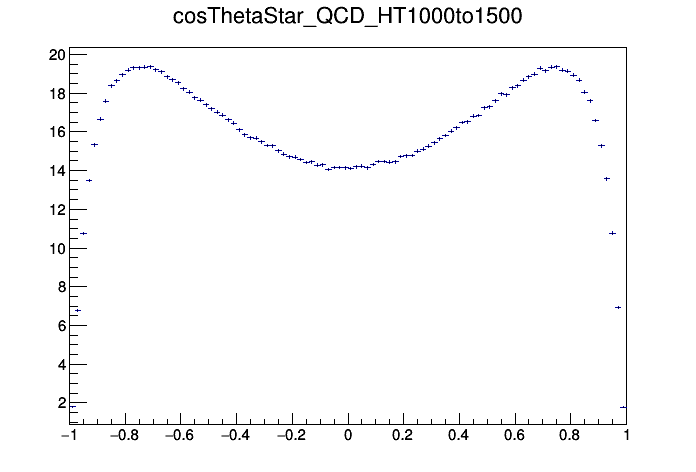

In [10]:
canvas = r.TCanvas()
hists["cosThetaStar_QCD_HT1000to1500"].Draw()
canvas.Draw()

In [11]:
for ihist, hname in enumerate(hists.iterkeys()):
    print ihist, hname

0 leadingEta_QCD_HT500to700
1 leadingEta_QCD_HT700to1000
2 dijetMass_QCD_HT700to1000
3 leadingEta_data
4 leadingEta_QCD_HT1000to1500
5 dijetMass_QCD_HT300to500
6 dijetEtBalance_QCD_HT2000toInf
7 cosThetaStar_QCD_HT2000toInf
8 dijetEtBalance_QCD_HT500to700
9 dijetEtBalance_QCD_HT1500to2000
10 subleadingEta_QCD_HT500to700
11 cosThetaStar_QCD_HT1000to1500
12 dijetMass_QCD_HT500to700
13 dijetEtBalance_data
14 subleadingEta_data
15 leadingEta_QCD_HT1500to2000
16 cosThetaStar_QCD_HT700to1000
17 cosThetaStar_QCD_HT1500to2000
18 subleadingEta_QCD_HT700to1000
19 dijetMass_QCD_HT1000to1500
20 cosThetaStar_data
21 subleadingEta_QCD_HT1500to2000
22 leadingEta_QCD_HT300to500
23 dijetEtBalance_QCD_HT1000to1500
24 leadingEta_QCD_HT2000toInf
25 dijetMass_data
26 subleadingEta_QCD_HT1000to1500
27 dijetMass_QCD_HT2000toInf
28 cosThetaStar_QCD_HT500to700
29 subleadingEta_QCD_HT300to500
30 dijetEtBalance_QCD_HT700to1000
31 cosThetaStar_QCD_HT300to500
32 dijetEtBalance_QCD_HT300to500
33 dijetMass_QCD_HT150

In [12]:
#colors = [r.kBlack,r.kRed,r.kBlue,r.kGreen,r.kMagenta,r.kOrange,r.kCyan,r.kPink,r.kBlack+2,r.kRed+2,r.kBlue+2,r.kGreen+2]
leadingEtaStack = r.THStack()
subleadingEtaStack = r.THStack()
dijetMassStack = r.THStack()
cosThetaStarStack = r.THStack()
dijetEtaBalanceStack = r.THStack()
for ihist, hname in enumerate(hists.iterkeys()):
    print "Doing {} ... ".format(hname)
    if "data" not in hname:
        hists[hname].Scale(1.0/0.313716235739)
    
    if "data" in hname:
        hists[hname].SetMarkerColor(r.kBlack)
        hists[hname].SetLineColor(r.kBlack)
        hists[hname].SetMarkerStyle(20)
    elif "leadingEta" in hname and not "subleadingEta" in hname:
        hists[hname].SetLineColor(leadingEtaStack.GetNhists()+2)
        hists[hname].SetFillColor(leadingEtaStack.GetNhists()+2)
        leadingEtaStack.Add(hists[hname])
    elif "subleadingEta" in hname:
        hists[hname].SetLineColor(subleadingEtaStack.GetNhists()+2)
        hists[hname].SetFillColor(subleadingEtaStack.GetNhists()+2)
        subleadingEtaStack.Add(hists[hname])
    elif "dijetMass" in hname:
        hists[hname].SetLineColor(dijetMassStack.GetNhists()+2)
        hists[hname].SetFillColor(dijetMassStack.GetNhists()+2)
        dijetMassStack.Add(hists[hname])
    elif "cosThetaStar" in hname:
        hists[hname].SetLineColor(cosThetaStarStack.GetNhists()+2)
        hists[hname].SetFillColor(cosThetaStarStack.GetNhists()+2)
        cosThetaStarStack.Add(hists[hname])
    elif "dijetEtaBalance" in hname:
        hists[hname].SetLineColor(dijetEtaBalanceStack.GetNhists()+2)
        hists[hname].SetFillColor(dijetEtaBalanceStack.GetNhists()+2)
        dijetEtaBalanceStack.Add(hists[hname])

Doing leadingEta_QCD_HT500to700 ... 
Doing leadingEta_QCD_HT700to1000 ... 
Doing dijetMass_QCD_HT700to1000 ... 
Doing leadingEta_data ... 
Doing leadingEta_QCD_HT1000to1500 ... 
Doing dijetMass_QCD_HT300to500 ... 
Doing dijetEtBalance_QCD_HT2000toInf ... 
Doing cosThetaStar_QCD_HT2000toInf ... 
Doing dijetEtBalance_QCD_HT500to700 ... 
Doing dijetEtBalance_QCD_HT1500to2000 ... 
Doing subleadingEta_QCD_HT500to700 ... 
Doing cosThetaStar_QCD_HT1000to1500 ... 
Doing dijetMass_QCD_HT500to700 ... 
Doing dijetEtBalance_data ... 
Doing subleadingEta_data ... 
Doing leadingEta_QCD_HT1500to2000 ... 
Doing cosThetaStar_QCD_HT700to1000 ... 
Doing cosThetaStar_QCD_HT1500to2000 ... 
Doing subleadingEta_QCD_HT700to1000 ... 
Doing dijetMass_QCD_HT1000to1500 ... 
Doing cosThetaStar_data ... 
Doing subleadingEta_QCD_HT1500to2000 ... 
Doing leadingEta_QCD_HT300to500 ... 
Doing dijetEtBalance_QCD_HT1000to1500 ... 
Doing leadingEta_QCD_HT2000toInf ... 
Doing dijetMass_data ... 
Doing subleadingEta_QCD_HT10

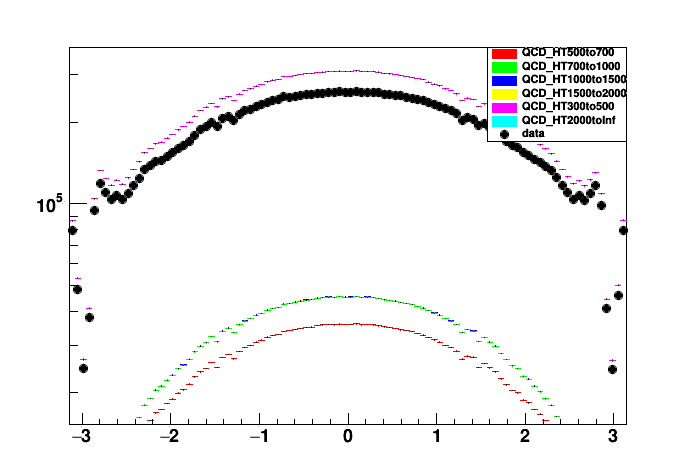

In [22]:
#r.gROOT.SetStyle("Plain")
canvas2 = r.TCanvas()
canvas2.SetLogy()
leadingEtaStack.Draw()
leadingEtaStack.GetYaxis().SetRangeUser(1.0,4e5)
hists["leadingEta_data"].Draw("Esame")
canvas2.Draw()
leg = r.TLegend(0.7,0.7,0.9,0.9)
for h in leadingEtaStack.GetHists():
    leg.AddEntry(h,h.GetName().replace("leadingEta_",""),"f")
leg.AddEntry(hists["leadingEta_data"],hists["leadingEta_data"].GetName().replace("leadingEta_",""),"p")
leg.Draw("same")

In [20]:
print leadingEtaStack.GetStack().Last().GetEntries()
print hists["leadingEta_data"].GetEntries()
print hists["leadingEta_data"].GetEntries()/leadingEtaStack.GetStack().Last().GetEntries()


59566423.0
18686954.0
0.313716235739
